In [1]:
# PASTE THIS TO THE FIRST CELL OF THE NOTEBOOK IN ORDER TO HAVE WORKING IMPORTS
import sys
import os
current_dir = os.getcwd()
parent_parent_dir = os.path.abspath(os.path.join(current_dir, '../..')) # tweak so that you get dir of code project

sys.path.append(parent_parent_dir)

In [2]:
from sklearn.cluster import OPTICS
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

## data import

In [3]:
from src.features.get_x_y_tuples import get_x_y_tuple_list
from src.features.get_first_and_last_x_y_coordinates import get_first_and_last_x_y_coordinates 
from src.features.get_first_x_y_coordinates import get_first_x_y_coordinates
from src.features.get_last_x_y_coordinates import get_last_x_y_coordinates
def import_data(df_path):
    df_cuid = pd.read_csv(df_path)
    df_cuid_grouped_path = df_path.replace('.csv', '_grouped.csv')
    df_cuid_grouped = pd.read_csv(df_cuid_grouped_path)
    # 1.1 CONVERT FEATURES TO NUMBERS
    df_cuid_grouped['x'] = df_cuid_grouped['x'].apply(lambda x: ast.literal_eval(x))
    df_cuid_grouped['y'] = df_cuid_grouped['y'].apply(lambda y: ast.literal_eval(y))
    list_x_y_tuples = get_x_y_tuple_list(df_cuid_grouped, ['x','y'])
    first_last_x_coords, first_last_y_coords = get_first_and_last_x_y_coordinates(list_x_y_tuples)
    X = np.array([first_last_x_coords, first_last_y_coords]).T

    first_x_coords, first_y_coords = get_first_x_y_coordinates(list_x_y_tuples)
    first_coordinates = np.array([first_x_coords, first_y_coords]).T

    last_x_coords, last_y_coords = get_last_x_y_coordinates(list_x_y_tuples)
    last_coordinates = np.array([last_x_coords, last_y_coords]).T
    return df_cuid, df_cuid_grouped, X, first_coordinates, last_coordinates, list_x_y_tuples
        

In [4]:
df_path_k729_2022 = f'{parent_parent_dir}/data/processed/k729_2022_cuid.csv'
df_path_k733_2020 = f'{parent_parent_dir}/data/processed/k733_2020_cuid.csv'
df_path_k733_2018 = f'{parent_parent_dir}/data/processed/k733_2018_cuid.csv'

df_cuid_k729_2022, df_cuid_grouped_k729_2022, X_k729_2022, first_coordinates_k729_2022, last_coordinates_k729_2022, list_x_y_tuples_k729_2022 = import_data(df_path_k729_2022)
df_cuid_k733_2020, df_cuid_grouped_k733_2020, X_k733_2020, first_coordinates_k733_2020, last_coordinates_k733_2020, list_x_y_tuples_k733_2020 = import_data(df_path_k733_2020)
df_cuid_k733_2018, df_cuid_grouped_k733_2018, X_k733_2018, first_coordinates_k733_2018, last_coordinates_k733_2018, list_x_y_tuples_k733_2018 = import_data(df_path_k733_2018)

In [5]:
# import json from path
import json
def import_json(json_path):
    with open(json_path, 'r') as f:
        json_file = json.load(f)
    return json_file
k729_2022_optimized_optics_params = import_json(f'{parent_parent_dir}/src/models/optics/optimized_optics_clustering_parameters/k729_2022_optics_optimized.json')
k733_2020_optimized_optics_params = import_json(f'{parent_parent_dir}/src/models/optics/optimized_optics_clustering_parameters/k733_2020_optics_optimized.json')
k733_2018_optimized_optics_params = import_json(f'{parent_parent_dir}/src/models/optics/optimized_optics_clustering_parameters/k733_2018_optics_optimized.json')

In [13]:
from src.models.ensure_distance_metric_params import ensure_distance_metric_params
from src.models.DISTANCE_METRICS_WITH_ADDITIONAL_ARGS import DISTANCE_METRICS_WITH_ADDITIONAL_ARGS
def get_optimized_model_from_eval_metric(X, eval_metric, optimized_params):
    if optimized_params[eval_metric]['metric'] in DISTANCE_METRICS_WITH_ADDITIONAL_ARGS: 
        metric_params = ensure_distance_metric_params(X, [optimized_params[eval_metric]['metric']])[optimized_params[eval_metric]['metric']]
    else:
        metric_params = {}
    xi_kwarg = {'xi': optimized_params[eval_metric]['xi']} if optimized_params[eval_metric]['xi'] is not None else {}
    return OPTICS(max_eps=optimized_params[eval_metric]['epsilon'],
                  min_samples=optimized_params[eval_metric]['min_samples'],
                  metric=optimized_params[eval_metric]['metric'],
                  cluster_method=optimized_params[eval_metric]['cluster_method'],
                  metric_params=metric_params,
                  **xi_kwarg)


#### fit models

In [14]:
k729_2022_optics_model_optimized_silhouette = get_optimized_model_from_eval_metric(X_k729_2022, 'silhouette', k729_2022_optimized_optics_params)
k729_2022_optics_model_optimized_silhouette.fit(X_k729_2022)

OPTICS(cluster_method='dbscan', eps=4.5, metric='manhattan', metric_params={})

In [15]:
k733_2020_optics_model_optimized_silhouette = get_optimized_model_from_eval_metric(X_k733_2020, 'silhouette', k733_2020_optimized_optics_params)
k733_2020_optics_model_optimized_silhouette.fit(X_k733_2020)

OPTICS(eps=0.1, metric='chebyshev', metric_params={}, min_samples=8, xi=0.03)

In [16]:
k733_2018_optics_model_optimized_silhouette = get_optimized_model_from_eval_metric(X_k733_2018, 'silhouette', k733_2018_optimized_optics_params)
k733_2018_optics_model_optimized_silhouette.fit(X_k733_2018)

OPTICS(cluster_method='dbscan', eps=0.30000000000000004, metric='mahalanobis',
       metric_params={'VI': array([[ 0.00222897, -0.00150084],
       [-0.00150084,  0.0046552 ]])},
       min_samples=7)

#### calculate medoids

In [17]:
from src.models.optics.calculate_cluster_medoids import calculate_cluster_medoids
k729_2022_optics_silhouette_medoids = calculate_cluster_medoids(X=X_k729_2022, optics_model=k729_2022_optics_model_optimized_silhouette)
k733_2020_optics_silhouette_medoids = calculate_cluster_medoids(X=X_k733_2020, optics_model=k733_2020_optics_model_optimized_silhouette)
k733_2018_optics_silhouette_medoids = calculate_cluster_medoids(X=X_k733_2018, optics_model=k733_2018_optics_model_optimized_silhouette)


#### plot 

***All vehicle tracks rendered succesfully***


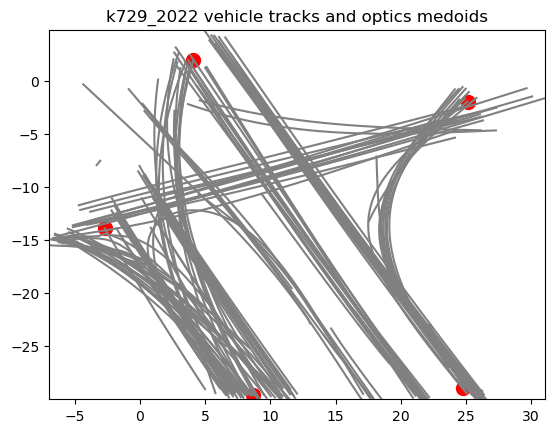

In [18]:
from src.visualization.plot_vehicle_tracks_in_notebook import plot_vehicle_tracks_in_notebook
import matplotlib.pyplot as plt

plot_vehicle_tracks_in_notebook(plt.gca(), df_cuid_k729_2022, df_cuid_grouped_k729_2022, 'k729_2022 vehicle tracks and optics medoids', color='gray')
plt.gca().scatter(k729_2022_optics_silhouette_medoids[:,0], k729_2022_optics_silhouette_medoids[:,1], c='red', s=100)

***All vehicle tracks rendered succesfully***


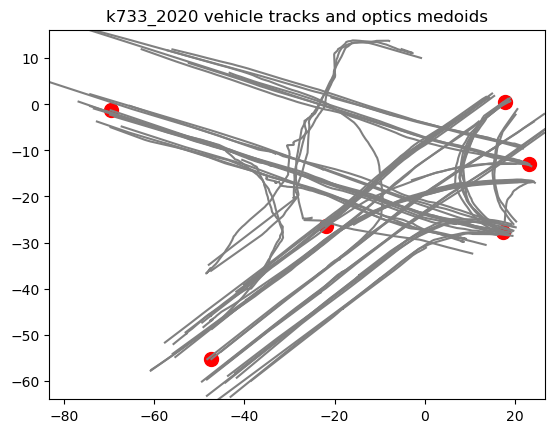

In [19]:
plt.clf()
plot_vehicle_tracks_in_notebook(plt.gca(), df_cuid_k733_2020, df_cuid_grouped_k733_2020, 'k733_2020 vehicle tracks and optics medoids', color='gray')
plt.gca().scatter(k733_2020_optics_silhouette_medoids[:,0], k733_2020_optics_silhouette_medoids[:,1], c='red', s=100)


***All vehicle tracks rendered succesfully***


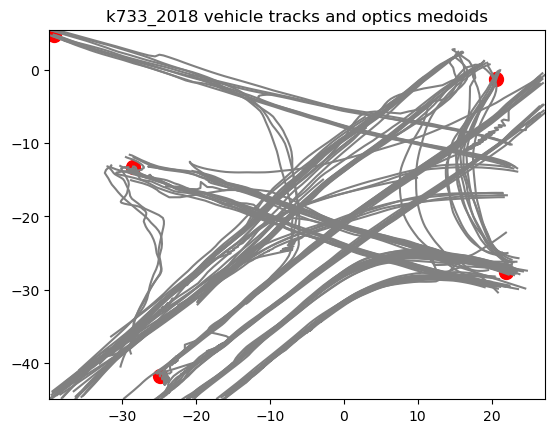

In [20]:
plt.clf()
plot_vehicle_tracks_in_notebook(plt.gca(), df_cuid_k733_2018, df_cuid_grouped_k733_2018, 'k733_2018 vehicle tracks and optics medoids', color='gray')
plt.gca().scatter(k733_2018_optics_silhouette_medoids[:,0], k733_2018_optics_silhouette_medoids[:,1], c='red', s=100)